In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import sys

sys.path.insert(0, "./../")
from FileManager import FileManager
from misc import rcsetup
plt.rcdefaults()
rcsetup()

In [2]:
def get_color(x, cmap='hsv'):
    return plt.colormaps[cmap](x)

def darken_color(color, amount=0.33):
    amount = float(max(0.0, min(1.0, amount)))
    rgb = mpl.colors.to_rgb(color)
    hsv = mpl.colors.rgb_to_hsv(rgb)
    hsv[2] = max(0.0, hsv[2] * (1.0 - amount))
    return tuple(mpl.colors.hsv_to_rgb(hsv))

In [3]:
class Vocabulary:

    def __init__(self, word_counts):
        self.words = np.array([word for word, c in word_counts])
        self.counts = np.array([c for word, c in word_counts])
        self.word2token = {word:tok for tok, word in enumerate(self.words)}
        self.size = len(self.words)

    def get_count(self, word):
        if word not in self.word2token:
            return 0
        return self.counts[self.word2token.get(word)]

    def to_words(self, tokens):
        return " ".join([self.words[tok] for tok in tokens])

# Prepare word embeddings

In [4]:
VOCAB_SZ = 25_000
data_dir = os.path.join(os.getenv("DATASETPATH"), "enwiki", "min200")

data_fm = FileManager(data_dir)
word_counts = data_fm.load("word_counts.pickle")
vocab = Vocabulary(word_counts)

In [5]:
print(f"Computing Mstar... ", end="")
corpus_stats = data_fm.load("corpus_stats.pickle")
cL = corpus_stats["context_len"]
Cij, Crwij = corpus_stats["counts"], corpus_stats["counts_reweight"]
numcounts = Cij[:VOCAB_SZ, :VOCAB_SZ].sum()
Pij = Crwij[:VOCAB_SZ, :VOCAB_SZ] / (numcounts * (cL + 1)/2)
unigram = vocab.counts[:VOCAB_SZ] / vocab.counts[:VOCAB_SZ].sum()
PiPj = np.outer(unigram, unigram)
Mstar = 2*(Pij - PiPj)/(Pij + PiPj)
print("done.")

Computing Mstar... done.


In [6]:
def get_asym_embeds(M):
    M_gpu = torch.tensor(M, dtype=torch.float32).cuda()
    eigvals, eigvecs = torch.linalg.eigh(M_gpu)
    eigvals = eigvals.cpu().numpy().astype(np.float64)
    eigvecs = eigvecs.cpu().numpy().astype(np.float64)
    del M_gpu
    torch.cuda.empty_cache()
    
    signs = np.sign(eigvals)
    sort_idx = np.argsort(np.abs(eigvals))[::-1]
    eigvals = np.abs(eigvals)[sort_idx]
    signs = signs[sort_idx]
    eigvecs = eigvecs[:, sort_idx]
    embeds = eigvecs * np.sqrt(eigvals[None, :])
    return embeds, signs

embeds, signs = get_asym_embeds(Mstar)

# Years

In [7]:
years = np.arange(1700, 2021)

year_idxs = []
for year in years:
  if vocab.word2token[str(year)] >= VOCAB_SZ:
    print(year)
    continue
  year_idxs.append(vocab.word2token[str(year)])
year_idxs = np.array(year_idxs)
N = len(year_idxs)

cc = (years-years.min())/(years.max()-years.min())
year_colors = np.array(get_color(cc, cmap='rainbow'))[::-1]

In [8]:
width = 125
amp = 5.8
FUNCTIONAL_FORM = lambda x: amp * np.exp(-np.abs(x) / width)

In [9]:
dx = years[:, None] - years[None, :]
distances = np.abs(dx)
M_th = FUNCTIONAL_FORM(distances)
centering = np.eye(N) - np.ones((N, N))/N
M_th = centering @ M_th @ centering
W_th_num, _ = get_asym_embeds(M_th)

In [10]:
d_max = 25_000
W_years = embeds[year_idxs, :d_max]
gram = W_years @ W_years.T
mu = W_years.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((W_years - mu), full_matrices=False)
embeds_years = (W_years - mu) @ Vt.T

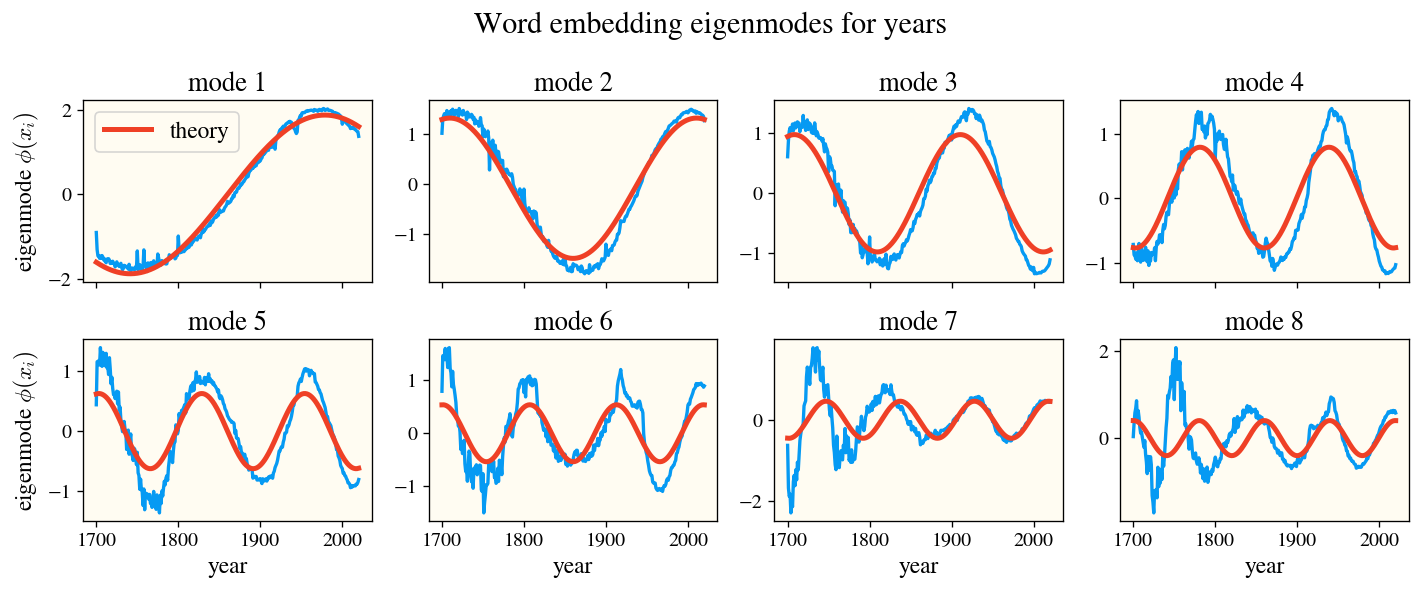

In [11]:
from scipy.optimize import bisect

def solve_k_sin(sigma, mu):
    f = lambda k: (mu+1)*np.pi/2 - np.arctan2(sigma*k, 1) - k
    return bisect(f, 0, (mu+1)*np.pi, xtol=1e-12)

def solve_k_cos(sigma, mu):
    f = lambda k: mu*np.pi/2 + np.arctan(k/ (1 + sigma*(1+sigma)*(k**2))) - k
    return bisect(f, 0, mu*np.pi, xtol=1e-12)

sigma = 2 * width/N
xx = np.linspace(-1, 1, N)
W_th = np.zeros((N, 8))
flip_axes = [1, 3, 4, 5, 6]
for i in range(8):
    if i % 2 == 0:
        k = solve_k_sin(sigma, i+1)
        th_curve = np.sin(k*xx)
    else:
        k = solve_k_cos(sigma, i+1)
        th_curve = np.cos(k*xx) - np.sin(k) / (k)
    th_curve /= np.sqrt(2/N) * np.linalg.norm(th_curve)
    eigval = amp * 2*sigma / (1 + sigma**2 * k**2)
    W_th[:, i] = np.sqrt(eigval) * th_curve
    if i in flip_axes:
        W_th[:, i] *= -1
        
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,5), sharex=True)
for i, ax in enumerate(axes.flat):
    ax.plot(years, embeds_years[:, i], lw=2, color='xkcd:azure')
    ax.plot(years, 1.33*W_th[:, i], color='xkcd:tomato', lw=3,
            label='theory')
    ax.set_title(f'mode {i+1}', fontsize=16)
    if i == 0:
        ax.legend(fontsize=14)
    if i > 3:
        ax.set_xlabel("year", fontsize=14)
    if i % 4 == 0:
        ax.set_ylabel(f"eigenmode $\\phi(x_i)$", fontsize=14)
    
fig.suptitle("Word embedding eigenmodes for years", fontsize=18)
plt.tight_layout()
plt.show()

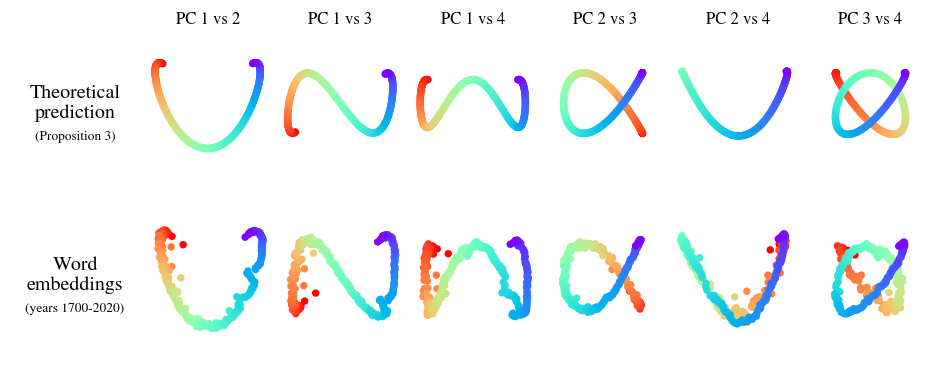

In [12]:
def plot_pca_scatter_grid(fig, W_th, embeds_years, year_colors,
                         pairs=None, sizes=None, flip_axes=None,
                         row_titles=None, row_subtitles=None):
    # Set defaults
    if pairs is None:
        pairs = [(0,1), (0,2), (0,3), (1,2), (1,3), (2,3)]
    if sizes is None:
        sizes = [0.6, 0.6, 0.6, 0.8, 0.6, 0.9]
    if flip_axes is None:
        flip_axes = [2, 3]
    if row_titles is None:
        row_titles = ["Theoretical\nprediction", "Word\nembeddings"]
    if row_subtitles is None:
        row_subtitles = ["(Proposition 3)", "(years 1700-2020)"]
    
    # Create gridspec on the provided figure
    gs = fig.add_gridspec(
        nrows=2, ncols=7,
        width_ratios=[1] + [1]*6,
        wspace=0.05, hspace=0.01,
        left=0.02, right=0.98, top=0.95, bottom=0.0
    )
    
    # Create axes
    axes = np.empty((2, 6), dtype=object)
    label_axes = []
    for i in range(2):
        label_axes.append(fig.add_subplot(gs[i, 0]))
        for j in range(6):
            axes[i, j] = fig.add_subplot(gs[i, j+1])
    
    # Add row labels
    for i, ax in enumerate(label_axes):
        ax.text(0.5, 0.5, row_titles[i], rotation=0,
                ha="center", va="center", fontsize=12)
        ax.text(0.5, 0.3, row_subtitles[i], rotation=0,
                ha="center", va="center", fontsize=8)
        ax.set_axis_off()
    
    # Create scatter plots
    col_titles = [f"PC {i+1} vs {j+1}" for i, j in pairs]
    for i, j in np.ndindex(axes.shape):
        ax = axes[i, j]
        x_idx, y_idx = pairs[j]
        
        if i == 0:
            scatter_x = W_th[:, x_idx]
            scatter_y = W_th[:, y_idx]
        else:
            scatter_x = embeds_years[:, x_idx]
            scatter_y = embeds_years[:, y_idx]
        if x_idx in flip_axes:
            scatter_x = -scatter_x
        if y_idx in flip_axes:
            scatter_y = -scatter_y
        ax.scatter(scatter_x, scatter_y,
                   c=year_colors, s=12)
        
        if i == 0:
            ax.set_title(col_titles[j], fontsize=10)
        if j == 0:
            ax.set_ylabel(row_titles[i], fontsize=10, rotation=90)

        ax.set_aspect(1.1, adjustable='box')
        ax.set_axis_off()
        extent = sizes[j] * max(scatter_x.max() - scatter_x.min(),
                            scatter_y.max() - scatter_y.min())
        ax.set_xlim(-extent, extent)
        ax.set_ylim(-extent, extent)
        ax.tick_params(labelleft=False, labelbottom=False)
    
    return fig

fig = plt.figure(figsize=(8,3))
plot_pca_scatter_grid(fig, W_th, embeds_years, year_colors)
plt.show()

In [13]:
embeds_decode = embeds_years[-121:].copy()
mu = embeds_decode.mean(axis=0, keepdims=True)
_, _, Vt = np.linalg.svd((embeds_decode - mu), full_matrices=False)
embeds_decode = (embeds_decode - mu) @ Vt.T
coords = years[-121:].copy().astype(float)

V, d = embeds_decode.shape

coords -= coords.mean()
d_probes = np.unique(np.logspace(-1, 2, 43).astype(int))
print(len(d_probes))
ridges = np.logspace(-8, 2, 50)
ntrials = 100
ntrain = 60
test_mses = np.zeros((len(d_probes), len(ridges), ntrials))
train_mses = np.zeros((len(d_probes), len(ridges), ntrials))

for i, d_probe in enumerate(d_probes):
    if d_probe < 1:
        d_probe = 0
    for j, ridge in enumerate(ridges):
        for trial in range(ntrials):
            train_idx, test_idx = np.split(np.random.permutation(len(coords)), [ntrain])
            coords_train, coords_test = coords[train_idx], coords[test_idx]
            W_train, W_test = embeds_decode[train_idx, :d_probe], embeds_decode[test_idx, :d_probe]
            probe = np.linalg.solve(W_train.T @ W_train + ridge*np.eye(W_train.shape[1]),
                                    W_train.T @ coords_train)
            coords_pred = W_test @ probe
            mse = np.std(coords_test-coords_pred) / np.std(coords_test)
            train_mse = np.std(coords_train - (W_train @ probe)) / np.std(coords_train)
            test_mses[i, j, trial] = mse
            train_mses[i, j, trial] = train_mse
    print('.', end='')
print()

train_mse_mean = train_mses.mean(axis=2)
train_mse_std = train_mses.std(axis=2)
test_mse_mean = test_mses.mean(axis=2)
test_mse_std = test_mses.std(axis=2)

24
........................


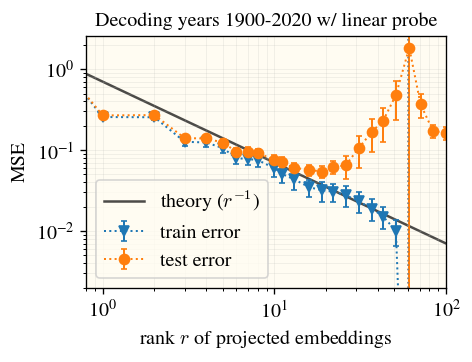

In [14]:
def plot_decoding_error(fig, d_probes, train_mse_mean, train_mse_std,
                        test_mse_mean, test_mse_std, opt_ridge_idx, ntrain):
    
    train_mse_mean_opt = train_mse_mean[np.arange(len(d_probes)), opt_ridge_idx]
    train_mse_std_opt  = train_mse_std [np.arange(len(d_probes)), opt_ridge_idx]
    test_mse_mean_opt  = test_mse_mean [np.arange(len(d_probes)), opt_ridge_idx]
    test_mse_std_opt   = test_mse_std  [np.arange(len(d_probes)), opt_ridge_idx]

    # Use gridspec with proper margins to keep everything inside the subfigure
    gs = fig.add_gridspec(1, 1, left=0.2, right=0.95, top=0.9, bottom=0.2)
    ax = fig.add_subplot(gs[0, 0])
    
    rr = d_probes.copy().astype(float)
    rr[0] = 0.6
    ax.errorbar(rr, train_mse_mean_opt, yerr=train_mse_std_opt,
                marker='v', lw=1.2, ls=':', capsize=2, label='train error')
    ax.errorbar(rr, test_mse_mean_opt, yerr=test_mse_std_opt,
                marker='o', lw=1.2, ls=':', capsize=2, label='test error')
    dd = np.logspace(np.log10(1e-2), np.log10(d_probes.max()), 100)
    th_curve = 0.7*dd**(-1.)
    ax.plot(dd, th_curve, zorder=-4, color="xkcd:black", alpha=0.7, label="theory ($r^{-1}$)")

    ax.axvline(ntrain, color='gray', ls=':', lw=1)

    ax.set_xlabel("rank $r$ of projected embeddings")
    ax.set_ylabel("MSE")
    # ax.set_ylabel("coordinate decoding MSE")
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim(left=8e-1, right=1e2)
    ax.set_ylim(bottom=2e-3, top=2.6)
    ax.set_title("Decoding years 1900-2020 w/ linear probe")
    # ax.set_title("Optimal ridge regularization")
    ax.legend()
    ax.grid(True, which="both", ls='-', lw=0.5, alpha=0.2)
    return ax

fig = plt.figure(figsize=(4,3))
opt_ridge_idx = train_mse_mean.argmin(axis=1)
plot_decoding_error(fig, d_probes, train_mse_mean, train_mse_std,
                    test_mse_mean, test_mse_std, opt_ridge_idx, ntrain)
plt.show()

# Figure 2

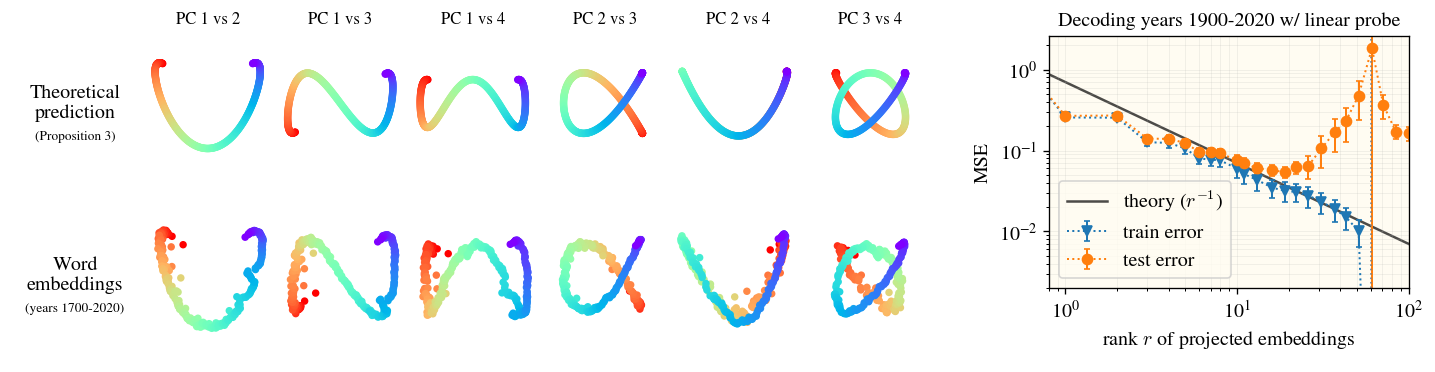

In [15]:
fig = plt.figure(figsize=(12, 3))
subfigs = fig.subfigures(1, 2, width_ratios=[8, 4])

# Outline subfigures to see their bounding boxes
# for sf in subfigs:
#     sf.patch.set_edgecolor('red')
#     sf.patch.set_linewidth(2)
#     sf.patch.set_facecolor('none')

plot_pca_scatter_grid(subfigs[0], W_th, embeds_years, year_colors)

opt_ridge_idx = train_mse_mean.argmin(axis=1)
plot_decoding_error(subfigs[1], d_probes, train_mse_mean, train_mse_std,
                    test_mse_mean, test_mse_std, opt_ridge_idx, ntrain)

plt.show()
# plt.savefig("plots/fig2.pdf", dpi=300, bbox_inches='tight')